# CNN Architecture comparison


In [13]:
# Imports and Setup
import os
import midi_access as midi # Helper functions in the midi_access.py file
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

sns.set_theme(style="whitegrid")


BASE_MIDI_DIR = './dataset_module_7'  
ARTISTS_DIR = os.path.join(BASE_MIDI_DIR, 'all_files')


# Data Preparation
from `main.ipynb`

In [14]:
def extract_tempo_features(pm):
    tempos, _ = pm.get_tempo_changes()
    return float(np.mean(tempos)), float(np.std(tempos))

def extract_note_stats(pm):
    pitches = [note.pitch for inst in pm.instruments for note in inst.notes]
    return len(pitches), len(set(pitches))

def extract_features(pm, top_chords):
    # reuse your pitch, IOI and chord histograms
    pitch = midi.get_pitch_class_histogram(pm)
    ioi   = midi.get_ioi_histogram(pm)
    chord = midi.get_chord_histogram(pm, top_chords)
    avg_t, std_t = extract_tempo_features(pm)
    total_n, uniq_n = extract_note_stats(pm)
    return np.concatenate([pitch, ioi, chord, [avg_t, std_t, total_n, uniq_n]])

In [15]:
# build a DataFrame of per‐song features
# Load all songs by artist
artist_midi_dict = midi.load_midi_files_by_artist(ARTISTS_DIR)
top_chords = midi.get_top_chords(artist_midi_dict, top_n=20)

song_features = []
for artist, song_list in artist_midi_dict.items():
    for idx, pm in enumerate(song_list):
        fv = extract_features(pm, top_chords)
        song_features.append({'artist': artist, 'song_idx': idx, 'features': fv})

df_song_features = pd.DataFrame(song_features)
df_song_features 

/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error loading ./dataset_module_7/all_files/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


,artist,song_idx,features
0,Mozart,0,"[0.06876872592381224, 0.010700527892709373, 0...."
1,Mozart,1,"[0.15384615384615385, 0.02234162895927602, 0.1..."
2,Mozart,2,"[0.008246649798519351, 0.09783525442788867, 0...."
3,Mozart,3,"[0.15336898395721926, 0.01411764705882353, 0.1..."
4,Mozart,4,"[0.20614568365203936, 0.007626837625732287, 0...."
...,...,...,...
475,Bach,117,"[0.0, 0.1256637168141593, 0.1079646017699115, ..."
476,Bach,118,"[0.09408142319534725, 0.041908997605200136, 0...."
477,Bach,119,"[0.00423728813559322, 0.134180790960452, 0.137..."
478,Bach,120,"[0.14699792960662525, 0.022774327122153208, 0...."


---

# Model Architecture and Training

## Data inputs 

In [16]:
# CNN Inputs
X = np.vstack(df_song_features['features'].values)
y = LabelEncoder().fit_transform(df_song_features['artist'])
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X_cnn_train = X_train[..., None]
X_cnn_val   = X_val[..., None]

In [17]:
# CNN Architecture
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam

# Training with callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First convolutional block
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Second convolutional block
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Third convolutional block
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the CNN model
model = create_cnn_model(input_shape=(X_cnn_train.shape[1], 1), num_classes=len(np.unique(y_train)))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

history = model.fit(
    X_cnn_train, y_train,
    validation_data=(X_cnn_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks
)



Epoch 1/100


/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2825 - loss: 2.2270 - val_accuracy: 0.4479 - val_loss: 1.3654 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3955 - loss: 1.8058 - val_accuracy: 0.3021 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4619 - loss: 1.7877 - val_accuracy: 0.2708 - val_loss: 1.3767 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4894 - loss: 1.5219 - val_accuracy: 0.2917 - val_loss: 1.3567 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5131 - loss: 1.3016 - val_accuracy: 0.2812 - val_loss: 1.4088 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5367 - loss: 1.1601 - val_accuracy: 0.2917 - val_loss: 1.4287 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5751 - loss: 1.1072 - val_accuracy: 0.29

CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 54, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 54, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,704,910 (17.95 MB)

 Trainable params: 1,568,004 (5.98 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 3,136,010 (11.96 MB)

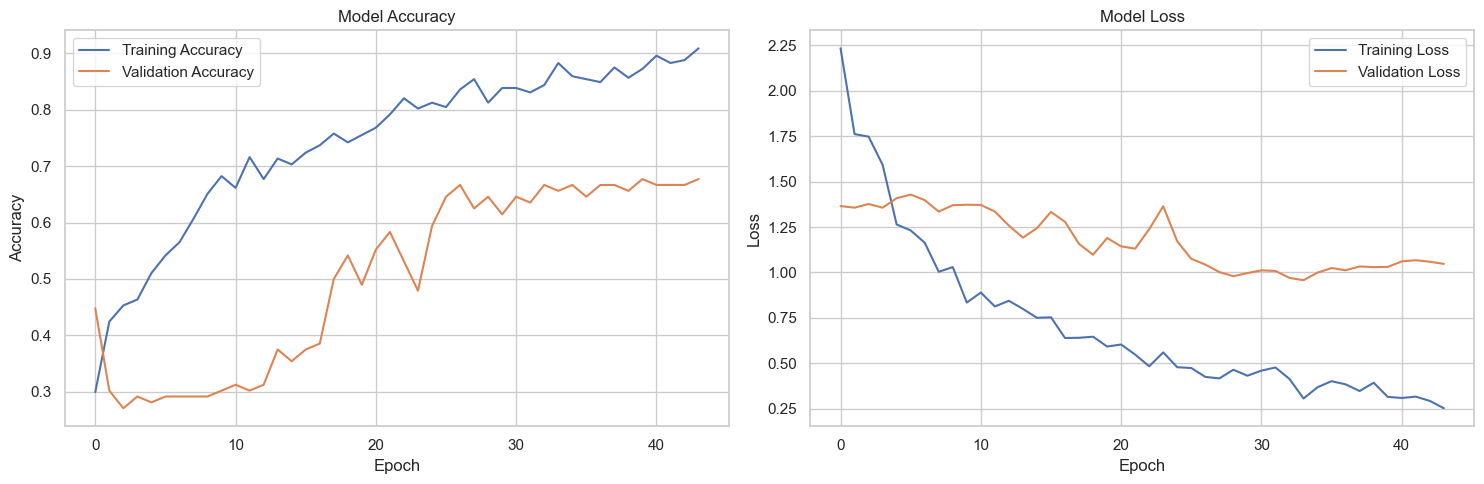


Final Training Accuracy: 0.9089
Final Validation Accuracy: 0.6771
Total epochs trained: 44


In [18]:
# Display model summary
print("CNN Model Architecture:")
model.summary()

# Display training progress
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final training results
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Total epochs trained: {len(history.history['accuracy'])}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:
              precision    recall  f1-score   support

        Bach       0.88      0.88      0.88        25
   Beethoven       0.50      0.62      0.55        26
      Chopin       0.89      0.59      0.71        27
      Mozart       0.43      0.50      0.46        18

    accuracy                           0.66        96
   macro avg       0.67      0.65      0.65        96
weighted avg       0.69      0.66      0.67        96



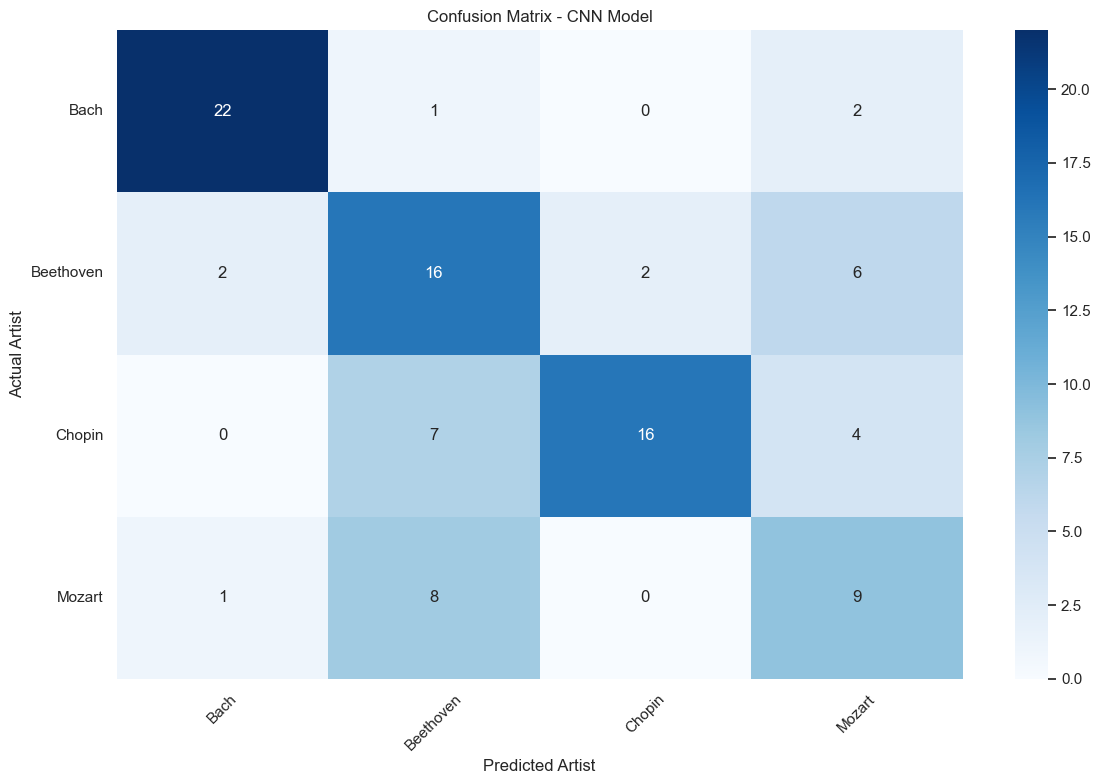

Bach: 0.880 accuracy
Beethoven: 0.615 accuracy
Chopin: 0.593 accuracy
Mozart: 0.500 accuracy


In [19]:
# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Make predictions
y_pred = model.predict(X_cnn_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get artist names for labels
le = LabelEncoder()
le.fit(df_song_features['artist'])
artist_names = le.classes_

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=artist_names))

# Confusion Matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=artist_names, yticklabels=artist_names)
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted Artist')
plt.ylabel('Actual Artist')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, artist in enumerate(artist_names):
    print(f"{artist}: {class_accuracy[i]:.3f} accuracy")

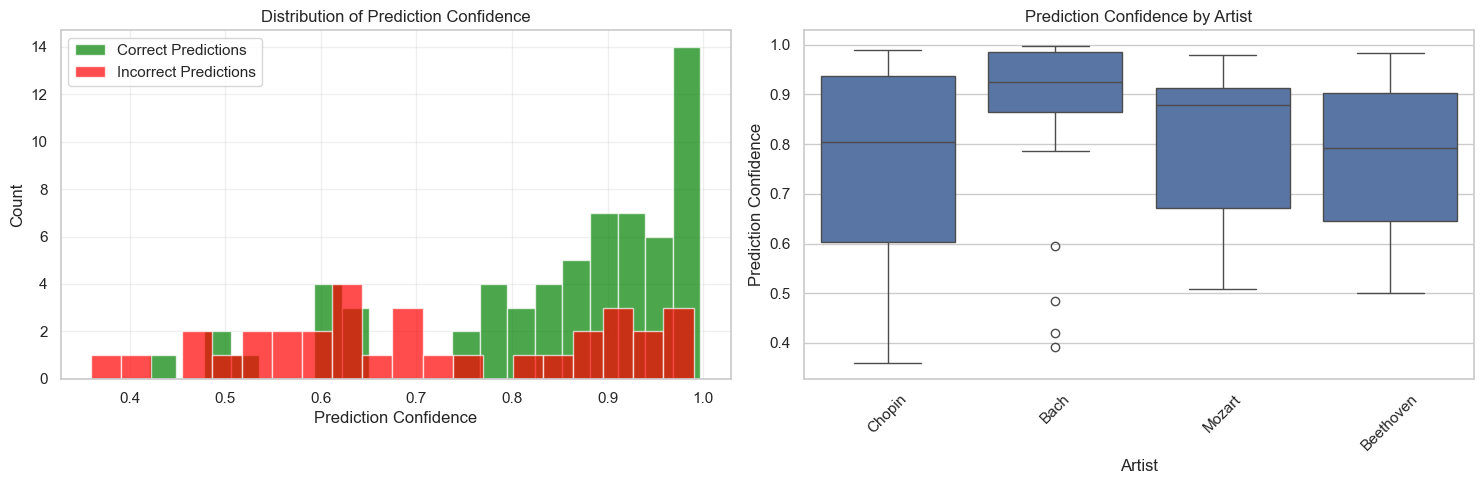


Low Confidence Predictions (confidence < 0.6):
       actual  predicted  confidence  correct
15     Chopin     Mozart    0.359876    False
30       Bach     Mozart    0.392658    False
77       Bach       Bach    0.419807     True
2      Chopin  Beethoven    0.479814    False
60       Bach  Beethoven    0.485027    False
14     Chopin     Chopin    0.497738     True
89  Beethoven     Mozart    0.501155    False
48  Beethoven  Beethoven    0.505433     True
49     Mozart     Mozart    0.507735     True
34  Beethoven     Mozart    0.526840    False


In [20]:
# Prediction Confidence Analysis
confidence_scores = np.max(y_pred, axis=1)
prediction_confidence = pd.DataFrame({
    'actual': [artist_names[i] for i in y_val],
    'predicted': [artist_names[i] for i in y_pred_classes],
    'confidence': confidence_scores,
    'correct': y_val == y_pred_classes
})

# Confidence distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(prediction_confidence[prediction_confidence['correct']]['confidence'], 
         alpha=0.7, label='Correct Predictions', bins=20, color='green')
plt.hist(prediction_confidence[~prediction_confidence['correct']]['confidence'], 
         alpha=0.7, label='Incorrect Predictions', bins=20, color='red')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Distribution of Prediction Confidence')
plt.legend()
plt.grid(True, alpha=0.3)

# Confidence by artist
plt.subplot(1, 2, 2)
sns.boxplot(data=prediction_confidence, x='actual', y='confidence')
plt.xticks(rotation=45)
plt.xlabel('Artist')
plt.ylabel('Prediction Confidence')
plt.title('Prediction Confidence by Artist')

plt.tight_layout()
plt.show()

# Print some low confidence predictions for analysis
print("\nLow Confidence Predictions (confidence < 0.6):")
low_confidence = prediction_confidence[prediction_confidence['confidence'] < 0.6].sort_values('confidence')
print(low_confidence.head(10))

## Alternativel CNN model

In [21]:
# Alternative Training Loop with Custom Monitoring

def train_cnn_with_monitoring(X_train, y_train, X_val, y_val, num_classes, epochs=100):
    """
    Custom training loop with detailed monitoring and early stopping
    """
    # Create fresh model
    model = create_cnn_model(input_shape=(X_train.shape[1], 1), num_classes=num_classes)
    
    # Compile with custom metrics
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Enhanced callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print("Starting CNN training with enhanced monitoring...")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Number of classes: {num_classes}")
    print("-" * 50)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

# Example usage - Train second model for comparison
model_v2, history_v2 = train_cnn_with_monitoring(
     X_cnn_train, y_train, X_cnn_val, y_val, 
     num_classes=len(np.unique(y_train)), 
     epochs=50
 )

print("Second CNN model trained successfully!")

Starting CNN training with enhanced monitoring...
Training samples: 384
Validation samples: 96
Number of classes: 4
--------------------------------------------------
Epoch 1/50


/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2756 - loss: 2.7112 - val_accuracy: 0.3021 - val_loss: 1.3763 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3441 - loss: 1.8741 - val_accuracy: 0.4062 - val_loss: 1.3631 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4691 - loss: 1.4610 - val_accuracy: 0.2708 - val_loss: 1.3683 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4453 - loss: 1.3689 - val_accuracy: 0.3021 - val_loss: 1.3684 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4848 - loss: 1.4072 - val_accuracy: 0.2500 - val_loss: 1.4200 - learning_rate: 0.0010
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5382 - loss: 1.2717 - val_accuracy: 0.3542 - val_loss: 1.3728 - learning_rate: 0.0010
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5657 - loss: 1.1080 - val_accuracy: 0.3854 - v

## Model comparison M1 and M2

COMPREHENSIVE MODEL COMPARISON
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


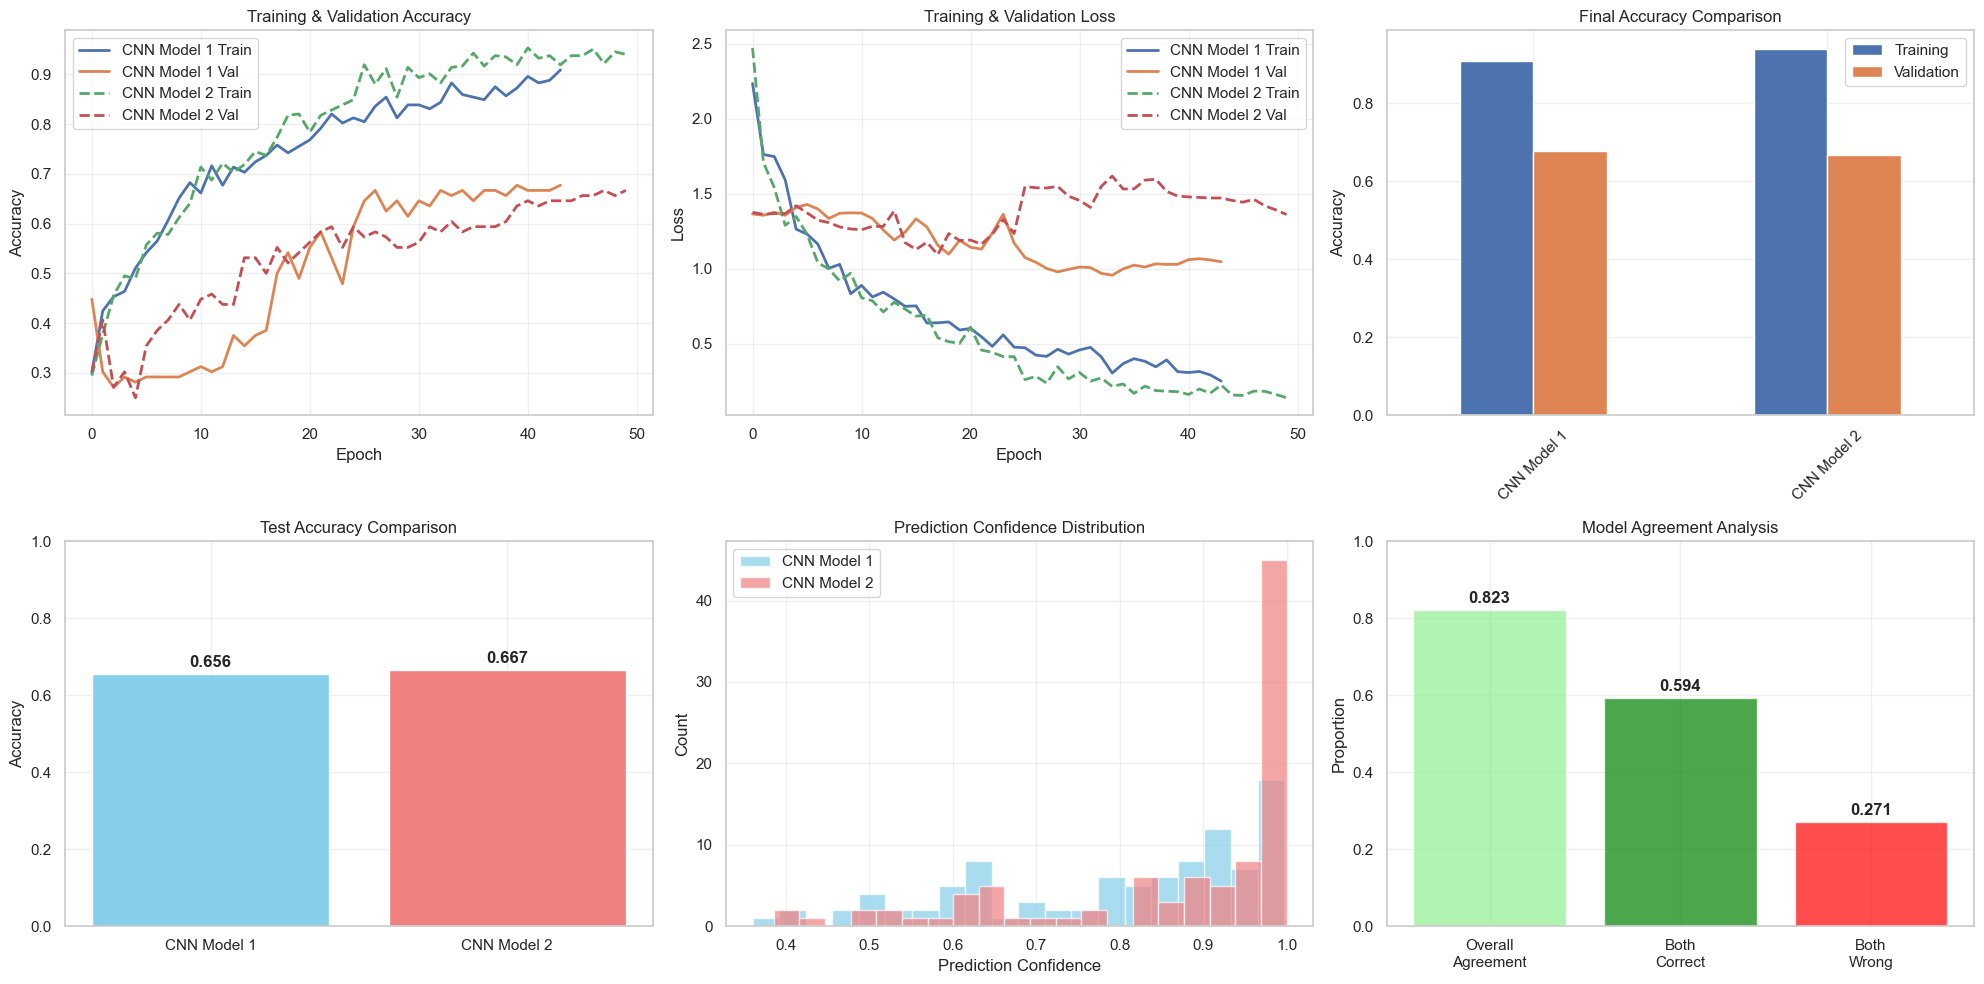


DETAILED PERFORMANCE COMPARISON
              Metric CNN Model 1 CNN Model 2
Final Train Accuracy      0.9089      0.9401
  Final Val Accuracy      0.6771      0.6667
       Test Accuracy      0.6562      0.6667
    Final Train Loss      0.2522      0.1413
      Final Val Loss      1.0469      1.3615
     Training Epochs          44          50
     Mean Confidence      0.7978      0.8715
      Std Confidence      0.1715      0.1704

MODEL AGREEMENT ANALYSIS
Models agree on: 82.3% of predictions
Both models correct: 59.4%
Both models wrong: 27.1%

Disagreement cases: 17 out of 96
Sample disagreements:
   actual model1_pred model2_pred  model1_conf  model2_conf
   Chopin   Beethoven      Chopin     0.479814     0.549714
   Chopin   Beethoven        Bach     0.588688     0.643936
   Mozart      Mozart        Bach     0.616888     0.638078
     Bach      Mozart        Bach     0.392658     0.773657
   Chopin      Chopin        Bach     0.876667     0.999938
   Mozart   Beethoven      Moz

In [22]:
# Model Comparison: CNN Model 1 vs CNN Model 2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

def compare_models(model1, model2, history1, history2, X_val, y_val, model_names=["Model 1", "Model 2"]):
    """
    Comprehensive comparison between two trained models
    """
    print("="*60)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("="*60)
    
    # 1. Training History Comparison
    plt.figure(figsize=(20, 10))
    
    # Accuracy comparison
    plt.subplot(2, 3, 1)
    plt.plot(history1.history['accuracy'], label=f'{model_names[0]} Train', linewidth=2)
    plt.plot(history1.history['val_accuracy'], label=f'{model_names[0]} Val', linewidth=2)
    plt.plot(history2.history['accuracy'], label=f'{model_names[1]} Train', linewidth=2, linestyle='--')
    plt.plot(history2.history['val_accuracy'], label=f'{model_names[1]} Val', linewidth=2, linestyle='--')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss comparison
    plt.subplot(2, 3, 2)
    plt.plot(history1.history['loss'], label=f'{model_names[0]} Train', linewidth=2)
    plt.plot(history1.history['val_loss'], label=f'{model_names[0]} Val', linewidth=2)
    plt.plot(history2.history['loss'], label=f'{model_names[1]} Train', linewidth=2, linestyle='--')
    plt.plot(history2.history['val_loss'], label=f'{model_names[1]} Val', linewidth=2, linestyle='--')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Final Performance Metrics
    plt.subplot(2, 3, 3)
    final_metrics = {
        model_names[0]: {
            'train_acc': history1.history['accuracy'][-1],
            'val_acc': history1.history['val_accuracy'][-1],
            'train_loss': history1.history['loss'][-1],
            'val_loss': history1.history['val_loss'][-1]
        },
        model_names[1]: {
            'train_acc': history2.history['accuracy'][-1],
            'val_acc': history2.history['val_accuracy'][-1],
            'train_loss': history2.history['loss'][-1],
            'val_loss': history2.history['val_loss'][-1]
        }
    }
    
    metrics_df = pd.DataFrame(final_metrics).T
    metrics_df[['train_acc', 'val_acc']].plot(kind='bar', ax=plt.gca())
    plt.title('Final Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.legend(['Training', 'Validation'])
    plt.grid(True, alpha=0.3)
    
    # 3. Predictions and Detailed Metrics
    y_pred1 = model1.predict(X_val)
    y_pred1_classes = np.argmax(y_pred1, axis=1)
    y_pred2 = model2.predict(X_val)
    y_pred2_classes = np.argmax(y_pred2, axis=1)
    
    # Accuracy comparison
    acc1 = accuracy_score(y_val, y_pred1_classes)
    acc2 = accuracy_score(y_val, y_pred2_classes)
    
    plt.subplot(2, 3, 4)
    plt.bar([model_names[0], model_names[1]], [acc1, acc2], color=['skyblue', 'lightcoral'])
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate([acc1, acc2]):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Confidence comparison
    conf1 = np.max(y_pred1, axis=1)
    conf2 = np.max(y_pred2, axis=1)
    
    plt.subplot(2, 3, 5)
    plt.hist(conf1, alpha=0.7, label=model_names[0], bins=20, color='skyblue')
    plt.hist(conf2, alpha=0.7, label=model_names[1], bins=20, color='lightcoral')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Count')
    plt.title('Prediction Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Agreement between models
    plt.subplot(2, 3, 6)
    agreement = (y_pred1_classes == y_pred2_classes).mean()
    both_correct = ((y_pred1_classes == y_val) & (y_pred2_classes == y_val)).mean()
    both_wrong = ((y_pred1_classes != y_val) & (y_pred2_classes != y_val)).mean()
    
    agreement_data = [agreement, both_correct, both_wrong]
    labels = ['Overall\nAgreement', 'Both\nCorrect', 'Both\nWrong']
    colors = ['lightgreen', 'green', 'red']
    
    plt.bar(labels, agreement_data, color=colors, alpha=0.7)
    plt.title('Model Agreement Analysis')
    plt.ylabel('Proportion')
    plt.ylim(0, 1)
    for i, v in enumerate(agreement_data):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 4. Detailed Performance Table
    print("\n" + "="*60)
    print("DETAILED PERFORMANCE COMPARISON")
    print("="*60)
    
    comparison_table = pd.DataFrame({
        'Metric': ['Final Train Accuracy', 'Final Val Accuracy', 'Test Accuracy', 
                   'Final Train Loss', 'Final Val Loss', 'Training Epochs',
                   'Mean Confidence', 'Std Confidence'],
        model_names[0]: [
            f"{final_metrics[model_names[0]]['train_acc']:.4f}",
            f"{final_metrics[model_names[0]]['val_acc']:.4f}",
            f"{acc1:.4f}",
            f"{final_metrics[model_names[0]]['train_loss']:.4f}",
            f"{final_metrics[model_names[0]]['val_loss']:.4f}",
            len(history1.history['accuracy']),
            f"{np.mean(conf1):.4f}",
            f"{np.std(conf1):.4f}"
        ],
        model_names[1]: [
            f"{final_metrics[model_names[1]]['train_acc']:.4f}",
            f"{final_metrics[model_names[1]]['val_acc']:.4f}",
            f"{acc2:.4f}",
            f"{final_metrics[model_names[1]]['train_loss']:.4f}",
            f"{final_metrics[model_names[1]]['val_loss']:.4f}",
            len(history2.history['accuracy']),
            f"{np.mean(conf2):.4f}",
            f"{np.std(conf2):.4f}"
        ]
    })
    
    print(comparison_table.to_string(index=False))
    
    # 5. Agreement Analysis
    print(f"\n{'='*60}")
    print("MODEL AGREEMENT ANALYSIS")
    print(f"{'='*60}")
    print(f"Models agree on: {agreement:.1%} of predictions")
    print(f"Both models correct: {both_correct:.1%}")
    print(f"Both models wrong: {both_wrong:.1%}")
    
    # Cases where models disagree
    disagreement_mask = y_pred1_classes != y_pred2_classes
    if disagreement_mask.sum() > 0:
        print(f"\nDisagreement cases: {disagreement_mask.sum()} out of {len(y_val)}")
        print("Sample disagreements:")
        
        le = LabelEncoder()
        le.fit(df_song_features['artist'])
        artist_names = le.classes_
        
        disagreement_df = pd.DataFrame({
            'actual': [artist_names[i] for i in y_val[disagreement_mask][:10]],
            'model1_pred': [artist_names[i] for i in y_pred1_classes[disagreement_mask][:10]],
            'model2_pred': [artist_names[i] for i in y_pred2_classes[disagreement_mask][:10]],
            'model1_conf': conf1[disagreement_mask][:10],
            'model2_conf': conf2[disagreement_mask][:10]
        })
        print(disagreement_df.to_string(index=False))
    
    return {
        'model1_accuracy': acc1,
        'model2_accuracy': acc2,
        'agreement': agreement,
        'both_correct': both_correct,
        'comparison_table': comparison_table
    }

# Run the comparison
comparison_results = compare_models(
    model, model_v2, 
    history, history_v2, 
    X_cnn_val, y_val,
    model_names=["CNN Model 1", "CNN Model 2"]
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


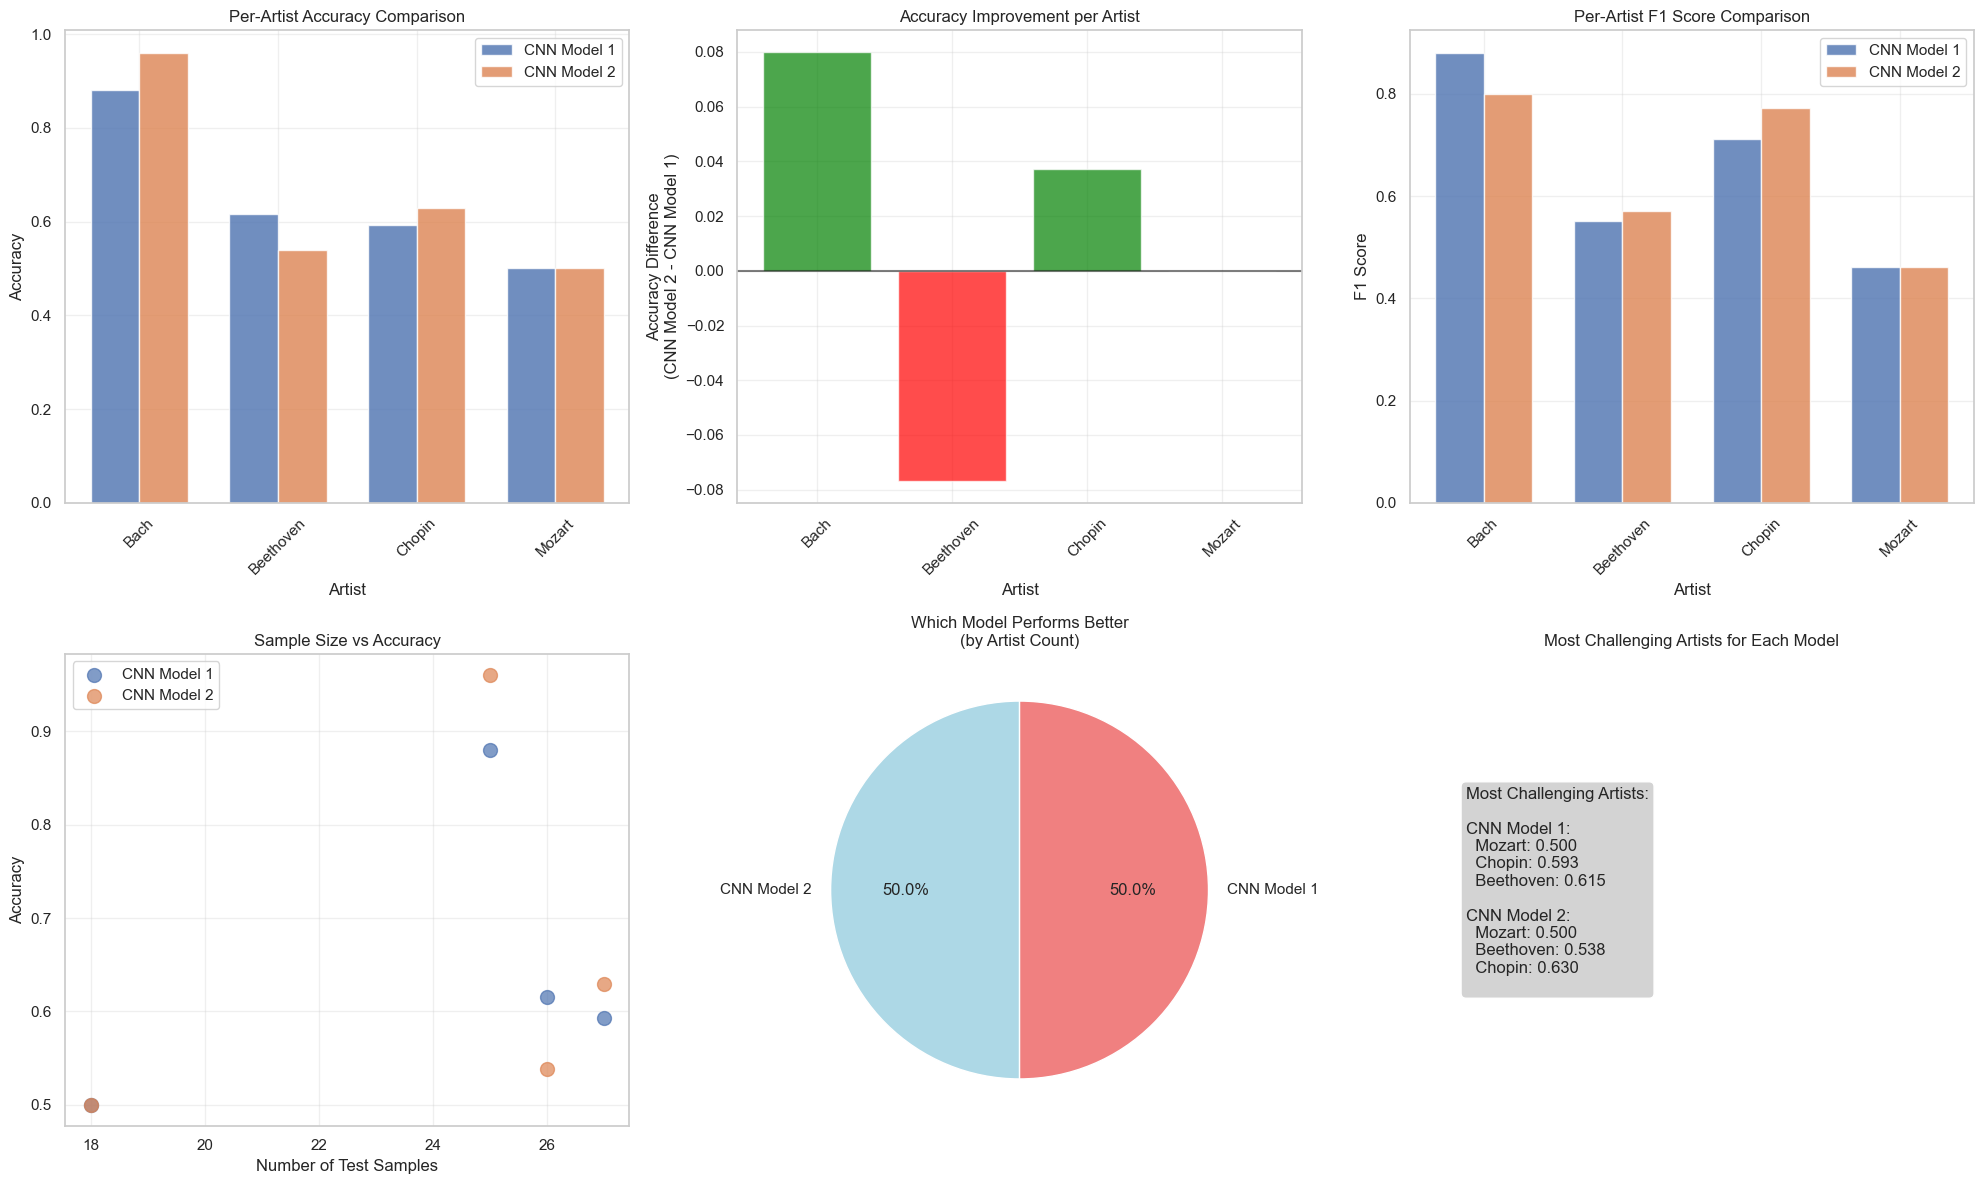

PER-ARTIST PERFORMANCE COMPARISON

Artist          Samples  CNN Model 1 Acc CNN Model 2 Acc Difference   Better Model   
--------------------------------------------------------------------------------
Bach            25       0.880        0.960        0.080        CNN Model 2    
Chopin          27       0.593        0.630        0.037        CNN Model 2    
Mozart          18       0.500        0.500        0.000        CNN Model 1    
Beethoven       26       0.615        0.538        -0.077       CNN Model 1    


In [23]:
# Per-Artist Performance Comparison
def compare_per_artist_performance(model1, model2, X_val, y_val, model_names=["Model 1", "Model 2"]):
    """
    Compare per-artist performance between two models
    """
    # Get predictions
    y_pred1 = np.argmax(model1.predict(X_val), axis=1)
    y_pred2 = np.argmax(model2.predict(X_val), axis=1)
    
    # Get artist names
    le = LabelEncoder()
    le.fit(df_song_features['artist'])
    artist_names = le.classes_
    
    # Calculate per-artist metrics
    artist_comparison = []
    
    for i, artist in enumerate(artist_names):
        # Get indices for this artist
        artist_mask = y_val == i
        if artist_mask.sum() == 0:
            continue
            
        # Calculate accuracy for each model
        acc1 = (y_pred1[artist_mask] == y_val[artist_mask]).mean()
        acc2 = (y_pred2[artist_mask] == y_val[artist_mask]).mean()
        
        # Calculate precision, recall, f1
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        # For binary classification per artist (artist vs others)
        y_true_binary = (y_val == i).astype(int)
        y_pred1_binary = (y_pred1 == i).astype(int)
        y_pred2_binary = (y_pred2 == i).astype(int)
        
        try:
            prec1 = precision_score(y_true_binary, y_pred1_binary, zero_division=0)
            recall1 = recall_score(y_true_binary, y_pred1_binary, zero_division=0)
            f1_1 = f1_score(y_true_binary, y_pred1_binary, zero_division=0)
            
            prec2 = precision_score(y_true_binary, y_pred2_binary, zero_division=0)
            recall2 = recall_score(y_true_binary, y_pred2_binary, zero_division=0)
            f1_2 = f1_score(y_true_binary, y_pred2_binary, zero_division=0)
        except:
            prec1 = recall1 = f1_1 = prec2 = recall2 = f1_2 = 0
        
        artist_comparison.append({
            'artist': artist,
            'samples': artist_mask.sum(),
            f'{model_names[0]}_accuracy': acc1,
            f'{model_names[1]}_accuracy': acc2,
            f'{model_names[0]}_precision': prec1,
            f'{model_names[1]}_precision': prec2,
            f'{model_names[0]}_f1': f1_1,
            f'{model_names[1]}_f1': f1_2,
            'accuracy_diff': acc2 - acc1,
            'better_model': model_names[1] if acc2 > acc1 else model_names[0]
        })
    
    df_comparison = pd.DataFrame(artist_comparison)
    
    # Visualization
    plt.figure(figsize=(20, 12))
    
    # Accuracy comparison
    plt.subplot(2, 3, 1)
    x = np.arange(len(artist_names))
    width = 0.35
    
    acc1_values = df_comparison[f'{model_names[0]}_accuracy'].values
    acc2_values = df_comparison[f'{model_names[1]}_accuracy'].values
    
    plt.bar(x - width/2, acc1_values, width, label=model_names[0], alpha=0.8)
    plt.bar(x + width/2, acc2_values, width, label=model_names[1], alpha=0.8)
    plt.xlabel('Artist')
    plt.ylabel('Accuracy')
    plt.title('Per-Artist Accuracy Comparison')
    plt.xticks(x, artist_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy difference
    plt.subplot(2, 3, 2)
    colors = ['green' if diff > 0 else 'red' for diff in df_comparison['accuracy_diff']]
    plt.bar(artist_names, df_comparison['accuracy_diff'], color=colors, alpha=0.7)
    plt.xlabel('Artist')
    plt.ylabel(f'Accuracy Difference\n({model_names[1]} - {model_names[0]})')
    plt.title('Accuracy Improvement per Artist')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # F1 Score comparison
    plt.subplot(2, 3, 3)
    f1_1_values = df_comparison[f'{model_names[0]}_f1'].values
    f1_2_values = df_comparison[f'{model_names[1]}_f1'].values
    
    plt.bar(x - width/2, f1_1_values, width, label=model_names[0], alpha=0.8)
    plt.bar(x + width/2, f1_2_values, width, label=model_names[1], alpha=0.8)
    plt.xlabel('Artist')
    plt.ylabel('F1 Score')
    plt.title('Per-Artist F1 Score Comparison')
    plt.xticks(x, artist_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sample size vs performance
    plt.subplot(2, 3, 4)
    plt.scatter(df_comparison['samples'], df_comparison[f'{model_names[0]}_accuracy'], 
                alpha=0.7, label=model_names[0], s=100)
    plt.scatter(df_comparison['samples'], df_comparison[f'{model_names[1]}_accuracy'], 
                alpha=0.7, label=model_names[1], s=100)
    plt.xlabel('Number of Test Samples')
    plt.ylabel('Accuracy')
    plt.title('Sample Size vs Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Model preference by artist
    plt.subplot(2, 3, 5)
    model_preference = df_comparison['better_model'].value_counts()
    plt.pie(model_preference.values, labels=model_preference.index, autopct='%1.1f%%',
            startangle=90, colors=['lightblue', 'lightcoral'])
    plt.title('Which Model Performs Better\n(by Artist Count)')
    
    # Confusion matrices side by side
    plt.subplot(2, 3, 6)
    
    # Calculate which artists each model struggles with most
    struggles_1 = []
    struggles_2 = []
    
    for i, artist in enumerate(artist_names):
        acc1 = df_comparison.iloc[i][f'{model_names[0]}_accuracy']
        acc2 = df_comparison.iloc[i][f'{model_names[1]}_accuracy']
        if acc1 < 0.7:
            struggles_1.append((artist, acc1))
        if acc2 < 0.7:
            struggles_2.append((artist, acc2))
    
    # Show most challenging artists
    struggles_1.sort(key=lambda x: x[1])
    struggles_2.sort(key=lambda x: x[1])
    
    challenge_text = f"Most Challenging Artists:\n\n{model_names[0]}:\n"
    for artist, acc in struggles_1[:3]:
        challenge_text += f"  {artist}: {acc:.3f}\n"
    
    challenge_text += f"\n{model_names[1]}:\n"
    for artist, acc in struggles_2[:3]:
        challenge_text += f"  {artist}: {acc:.3f}\n"
    
    plt.text(0.1, 0.5, challenge_text, fontsize=12, verticalalignment='center',
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    plt.axis('off')
    plt.title('Most Challenging Artists for Each Model')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison table
    print("="*80)
    print("PER-ARTIST PERFORMANCE COMPARISON")
    print("="*80)
    
    # Sort by accuracy difference
    df_display = df_comparison.sort_values('accuracy_diff', ascending=False)
    
    print(f"\n{'Artist':<15} {'Samples':<8} {model_names[0]+' Acc':<12} {model_names[1]+' Acc':<12} {'Difference':<12} {'Better Model':<15}")
    print("-" * 80)
    
    for _, row in df_display.iterrows():
        print(f"{row['artist']:<15} {row['samples']:<8} {row[f'{model_names[0]}_accuracy']:<12.3f} "
              f"{row[f'{model_names[1]}_accuracy']:<12.3f} {row['accuracy_diff']:<12.3f} {row['better_model']:<15}")
    
    return df_comparison

# Run per-artist comparison
artist_comparison_df = compare_per_artist_performance(
    model, model_v2, X_cnn_val, y_val,
    model_names=["CNN Model 1", "CNN Model 2"]
)

## Recomendation

ENSEMBLE MODEL EVALUATION
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Weighted ensemble: Model 1 weight = 0.496, Model 2 weight = 0.504
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model Performance Comparison:
           Method  Accuracy  Improvement_vs_Best
      CNN Model 1  0.656250            -0.010417
      CNN Model 2  0.666667             0.000000
 Average Ensemble  0.677083             0.010417
Weighted Ensemble  0.677083             0.010417
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


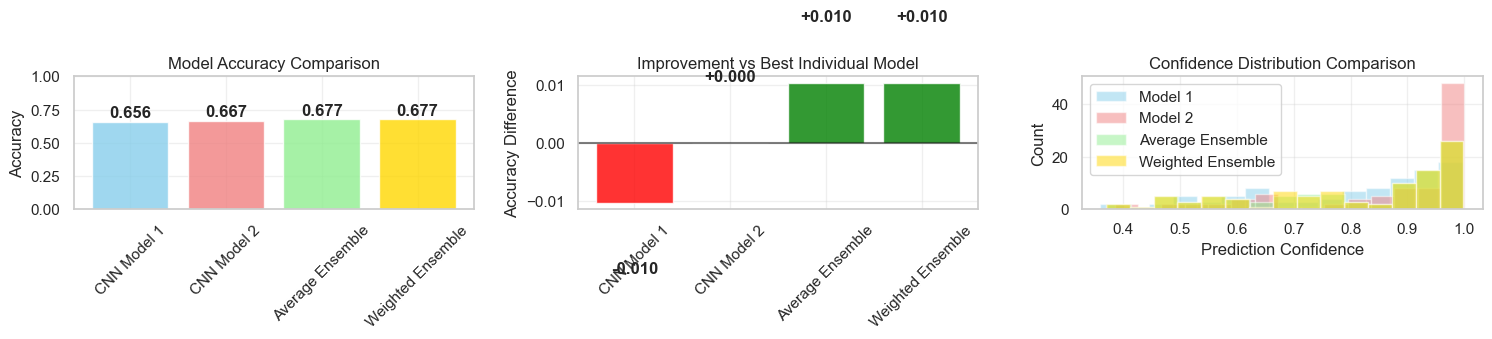


FINAL RECOMMENDATIONS

1. BEST INDIVIDUAL MODEL: CNN Model 2
   - Accuracy: 0.6667

2. BEST OVERALL APPROACH: Average Ensemble
   - Accuracy: 0.6771

3. ENSEMBLE BENEFIT: Yes! Ensemble improves accuracy by 0.0104

4. CONFIDENCE ANALYSIS:
   - Model 1 mean confidence: 0.7978
   - Model 2 mean confidence: 0.8715
   - Average ensemble confidence: 0.8061

5. TRAINING EFFICIENCY:
   - Model 1 trained for: 44 epochs
   - Model 2 trained for: 50 epochs

FINAL RECOMMENDATION: Use weighted ensemble for best performance


In [25]:
# Ensemble Method: Combining Both Models
def create_ensemble_predictions(model1, model2, X_val, y_val, method='average'):
    """
    Create ensemble predictions from two models
    """
    # Get probability predictions from both models
    pred1 = model1.predict(X_val)
    pred2 = model2.predict(X_val)
    
    if method == 'average':
        # Simple averaging
        ensemble_pred = (pred1 + pred2) / 2
    elif method == 'weighted':
        # Weight based on individual model performance
        acc1 = accuracy_score(y_val, np.argmax(pred1, axis=1))
        acc2 = accuracy_score(y_val, np.argmax(pred2, axis=1))
        
        # Normalize weights
        total_acc = acc1 + acc2
        w1, w2 = acc1/total_acc, acc2/total_acc
        
        ensemble_pred = w1 * pred1 + w2 * pred2
        print(f"Weighted ensemble: Model 1 weight = {w1:.3f}, Model 2 weight = {w2:.3f}")
    
    ensemble_classes = np.argmax(ensemble_pred, axis=1)
    ensemble_acc = accuracy_score(y_val, ensemble_classes)
    
    return ensemble_pred, ensemble_classes, ensemble_acc

# Test both ensemble methods
print("="*60)
print("ENSEMBLE MODEL EVALUATION")
print("="*60)

# Simple average ensemble
avg_pred, avg_classes, avg_acc = create_ensemble_predictions(
    model, model_v2, X_cnn_val, y_val, method='average'
)

# Weighted ensemble
weighted_pred, weighted_classes, weighted_acc = create_ensemble_predictions(
    model, model_v2, X_cnn_val, y_val, method='weighted'
)

# Individual model accuracies for comparison
model1_acc = accuracy_score(y_val, np.argmax(model.predict(X_cnn_val), axis=1))
model2_acc = accuracy_score(y_val, np.argmax(model_v2.predict(X_cnn_val), axis=1))

# Comparison results
results_df = pd.DataFrame({
    'Method': ['CNN Model 1', 'CNN Model 2', 'Average Ensemble', 'Weighted Ensemble'],
    'Accuracy': [model1_acc, model2_acc, avg_acc, weighted_acc],
    'Improvement_vs_Best': [
        model1_acc - max(model1_acc, model2_acc),
        model2_acc - max(model1_acc, model2_acc),
        avg_acc - max(model1_acc, model2_acc),
        weighted_acc - max(model1_acc, model2_acc)
    ]
})

print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

# Visualization
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 3, 1)
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
bars = plt.bar(results_df['Method'], results_df['Accuracy'], color=colors, alpha=0.8)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, results_df['Accuracy']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)

# Improvement visualization
plt.subplot(1, 3, 2)
improvements = results_df['Improvement_vs_Best']
colors = ['red' if x < 0 else 'green' for x in improvements]
bars = plt.bar(results_df['Method'], improvements, color=colors, alpha=0.8)
plt.title('Improvement vs Best Individual Model')
plt.ylabel('Accuracy Difference')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add value labels
for bar, imp in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.01 if imp >= 0 else -0.01), 
             f'{imp:+.3f}', ha='center', va='bottom' if imp >= 0 else 'top', fontweight='bold')

plt.grid(True, alpha=0.3)

# Confidence comparison
plt.subplot(1, 3, 3)
conf1 = np.max(model.predict(X_cnn_val), axis=1)
conf2 = np.max(model_v2.predict(X_cnn_val), axis=1)
conf_avg = np.max(avg_pred, axis=1)
conf_weighted = np.max(weighted_pred, axis=1)

plt.hist(conf1, alpha=0.5, label='Model 1', bins=15, color='skyblue')
plt.hist(conf2, alpha=0.5, label='Model 2', bins=15, color='lightcoral')
plt.hist(conf_avg, alpha=0.5, label='Average Ensemble', bins=15, color='lightgreen')
plt.hist(conf_weighted, alpha=0.5, label='Weighted Ensemble', bins=15, color='gold')

plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('Confidence Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final Recommendations
print("\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)

best_individual = "CNN Model 1" if model1_acc > model2_acc else "CNN Model 2"
best_overall = results_df.loc[results_df['Accuracy'].idxmax(), 'Method']

print(f"\n1. BEST INDIVIDUAL MODEL: {best_individual}")
print(f"   - Accuracy: {max(model1_acc, model2_acc):.4f}")

print(f"\n2. BEST OVERALL APPROACH: {best_overall}")
print(f"   - Accuracy: {results_df['Accuracy'].max():.4f}")

if avg_acc > max(model1_acc, model2_acc):
    print(f"\n3. ENSEMBLE BENEFIT: Yes! Ensemble improves accuracy by {avg_acc - max(model1_acc, model2_acc):.4f}")
else:
    print(f"\n3. ENSEMBLE BENEFIT: Minimal. Best individual model is sufficient.")

print(f"\n4. CONFIDENCE ANALYSIS:")
print(f"   - Model 1 mean confidence: {np.mean(conf1):.4f}")
print(f"   - Model 2 mean confidence: {np.mean(conf2):.4f}")
print(f"   - Average ensemble confidence: {np.mean(conf_avg):.4f}")

print(f"\n5. TRAINING EFFICIENCY:")
print(f"   - Model 1 trained for: {len(history.history['accuracy'])} epochs")
print(f"   - Model 2 trained for: {len(history_v2.history['accuracy'])} epochs")

recommendation = "weighted ensemble" if weighted_acc == results_df['Accuracy'].max() else best_overall.lower()
print(f"\nFINAL RECOMMENDATION: Use {recommendation} for best performance")